# Plot Figure 10

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import netCDF4 as nc
import os
from pathlib import Path

# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from metpy.plots import SkewT

In [6]:
file_path = Path("data/")
files = list(file_path.glob("*fig10*"))
#files = os.listdir(Path("data/*fig10*"))
#files.remove('GFDL-CM4-piControl-fig10.nc') # this one doesnt work, need to debug
#files

In [4]:
ps = 100000 * units.Pa # temporary hack, should interpolate pressure from daily timeseries

/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1114: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


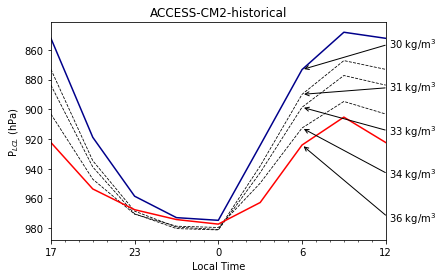

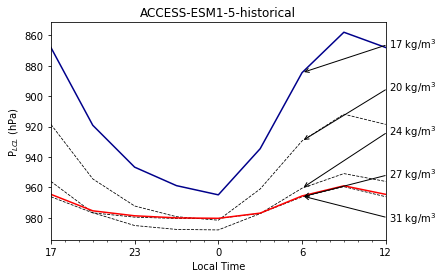

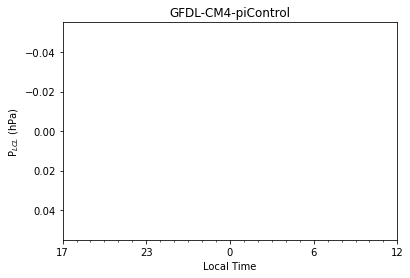

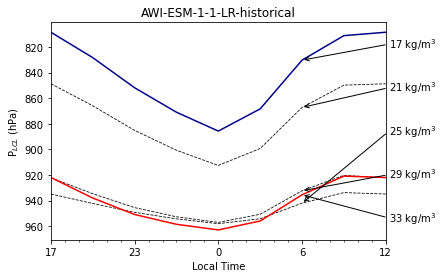

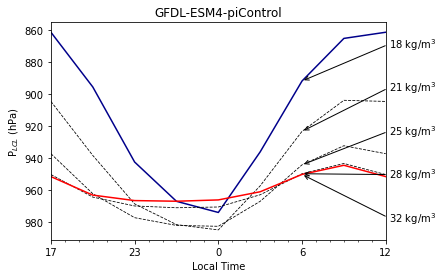

In [8]:
for data in files:
    # open the data and re-convert time to cftime so xarray is happy
    data_in = xr.open_dataset(data, engine="netcdf4", decode_times=False).metpy.quantify()
    #data_in["time"] = cftime.num2date(data_in.time, "hours since 1850-01-01 00:00:00", calendar="noleap", has_year_zero=True)
    data_in["time"] = cftime.num2date(data_in.time, "hours since 0001-01-01 03:00:00", calendar="noleap", has_year_zero=True)
    
    
    # use metpy to convert humidity field to dew point temp
    try:
        data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)
    except ValueError:
        data_in["tas"] = data_in.tas * units.kelvin
        data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)

    # compute the spatial average
    spatial_average = data_in.mean(dim=("lat", "lon"))

    # sort the file into 6 groups based on soil moisture content
    the_max = float(spatial_average.mrsos.max().values)
    the_min = float(spatial_average.mrsos.min().values)
    the_range =  the_max - the_min

    spatial_average["soil_moisture_grp"] = ((spatial_average.mrsos / (the_range / 6)).round() * (the_range / 6)).round()

    gbysoil = spatial_average.groupby(spatial_average.soil_moisture_grp)
    
    # remove the highest and lowest values, they are usually too sparse to plot
    mrsos_keys = list(gbysoil.groups.keys())
    mrsos_keys.remove(max(mrsos_keys))
    mrsos_keys.remove(min(mrsos_keys))
    
    # calculate and plot the average diurnal cycle of lcl height
    fig, ax = plt.subplots()
    lposition = 1.1 # for annotating plot
    for key in mrsos_keys:
        # group by hour
        hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.hour).mean(dim="time") 

        # find and plot the lcl
        plcl, tlcl = mpcalc.lcl(ps, hourly_data.tas, hourly_data.td)
        plcl_hpa = plcl / 100
        
        # assign colors to match Betts
        if key == min(mrsos_keys):
            plot_kwargs = {"color":"darkblue"}
        elif key == max(mrsos_keys):
            plot_kwargs = {"color":"red"}
        else:
            plot_kwargs = {"color":"black", "linestyle":"--", "linewidth":0.8}

        # append hour 24 to match hour 0
        the_time = np.append(hourly_data.hour.values, 24)
        the_lcl = np.append(plcl_hpa, plcl_hpa[0])
        ax.plot(the_time, the_lcl, **plot_kwargs)
        
        
        #the_label = ax.annotate(f"{round(key)} kg/m$^3$", (24, the_lcl[-1]))
        lposition -= 1 / 5
        ax.annotate(f"{round(key)} kg/m$^3$",
                    xy=(18, the_lcl[-3]), xycoords='data',
                    xytext=(1.01, lposition), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="->", relpos=(0,0.5)),
                    horizontalalignment='left', verticalalignment='center')

    # make the plot match Betts fig 11
    plt.gca().invert_yaxis()
    ax.set_xlabel("Local Time")
    ax.set_ylabel("P$_{LCL}$ (hPa)")
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks((0,6,12,18,24), labels=(17, 23, 0, 6, 12))

    ax.set_xlim(0,24)
    ax.set_title(str(data)[5:-9]);